# NFL Punt Analytics
### An Initial EDA
- Matthew Johnson, Dec 16, 2018

https://www.kaggle.com/c/NFL-Punt-Analytics-Competition

TODO:
- find area on field where injuries happen more
- does where the ball is caught matter
- formation?

In [357]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

path = '/Users/mattjohnson/Downloads/all/'

files = ['game_data.csv',
         'video_review.csv', 
         'video_footage-injury.csv', 
         'video_footage-control.csv', 
         'player_punt_data.csv',  # GSISID, Number, Position
         'play_player_role_data.csv',  # Season_Year, GameKey, PlayID, GSISID, Role
         'play_information.csv']

filenames = [fn.rstrip('.csv') for fn in files]

df_dict = {}

# Helps to aid in merging dataframes
def add_hashcode(df):
    if 'playid' in df.columns:
        if 'season' in df.columns:
            df['hashcode'] = df['season'].map(str) + '-' + df['gamekey'].map(str) + '-' + df['playid'].map(str)
        elif 'season_year' in df.columns:
            df['hashcode'] = df['season_year'].map(str) + '-' + df['gamekey'].map(str) + '-' + df['playid'].map(str)   
    return df

for name, file in zip(filenames, files):
    df_dict.update( {name: pd.read_csv(os.path.join(path, file))} )
    df_dict[name].columns = [col.lower() for col in df_dict[name].columns]
    df_dict[name] = add_hashcode(df_dict[name])

### Importing Next Gen Stats

In [2]:
ngs_ = 'NGS-2016-pre.csv'
ngs = pd.read_csv(os.path.join(path, ngs_))
ngs.columns = [col.lower() for col in ngs.columns]
ngs['gsisid'] = ngs['gsisid'].fillna(0).astype(int).astype('category')

date_format = '%Y-%m-%d %H:%M:%S.%f'
ngs['time'] = pd.to_datetime(ngs['time'], format=date_format)

ngs = add_hashcode(ngs)

In [246]:
def get_player_gsisids(hashcode):
    df = df_dict['video_review'][ df_dict['video_review']['hashcode'] == hashcode]  
    try:
        return [df['gsisid'].values[0], int(df['primary_partner_gsisid'].values[0])]
    except:
        return []     

## Distributions of Variables

We can see that during punts, the activity that results in the most concussions is tackling.

In [464]:
#import matplotlib.style as style
#style.use('fivethirtyeight')
sns.set_palette(sns.color_palette("Set2"))
#sns.set_style('white')

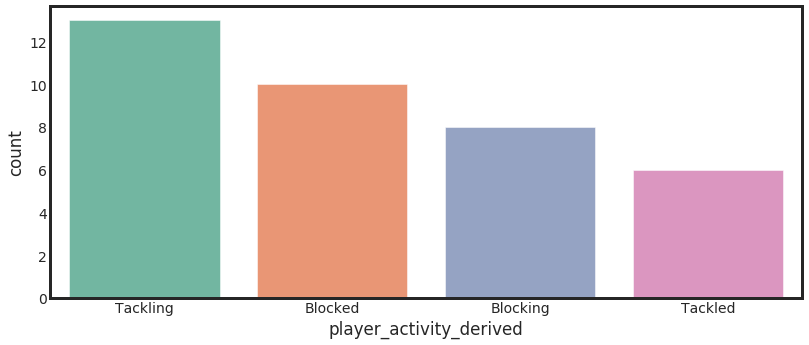

In [465]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(111)
sns.countplot(df_dict['video_review']['player_activity_derived']);

We see here that Helmet-to-body and Helmet-to-helmet are the key contributors with regards to impact type.

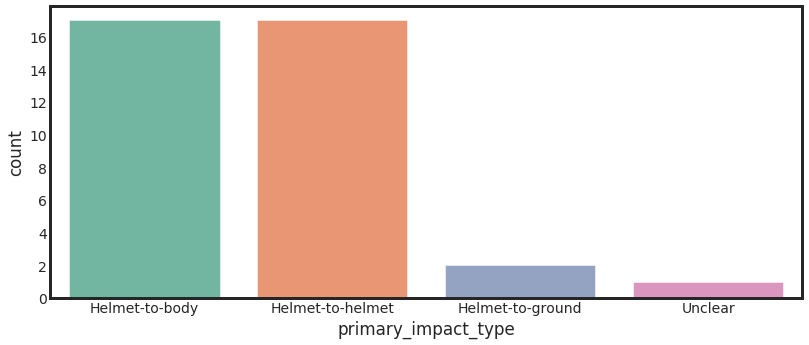

In [466]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(111)
sns.countplot(df_dict['video_review']['primary_impact_type']);

In [452]:
print('control',df_dict['video_footage-control'].shape)
print('injury',df_dict['video_footage-injury'].shape)

control (37, 11)
injury (37, 11)


### Merge the Dataframes:

In [30]:
injurydf = pd.merge(left=df_dict['video_review'], right=df_dict['video_footage-injury'], on='hashcode', how='inner')
injurydf = pd.merge(left=injurydf, right=df_dict['play_information'], on='hashcode', how='inner')

controldf = df_dict['video_footage-control']

cols = ['season', 'gamekey', 'playid', 'type', 'week_x', 'gsisid','player_activity_derived', 
        'turnover_related', 'primary_impact_type', 'primary_partner_gsisid', 'primary_partner_activity_derived', 
        'friendly_fire', 'hashcode', 'home_team', 'visit_team', 'qtr', 'playdescription_x', 'game_date', 
        'game_clock', 'yardline', 'play_type', 'poss_team', 'home_team_visit_team', 'score_home_visiting', 
        'preview link (5000k)']

injurydf = injurydf[cols]
injurydf.columns = [col.rstrip('_x') for col in injurydf.columns]

## Visualizing Motion

Plotting velocity, acceleration, and orientation during the play

We first experiment with the play '2016-5-3129'

In [391]:
# TODO: break this up, need to only calculate values once but calling multiple times to get data
def get_2_players(hashcode):
    
    ngs['gsisid'] = ngs['gsisid'].astype(int)
    game = ngs[ ngs['hashcode']==hashcode]

    player_gsisids = get_player_gsisids(hashcode)

    p1 = game[ game['gsisid'] == player_gsisids[0]].copy()
    p2 = game[ game['gsisid'] == player_gsisids[1]].copy()
    players = [p1, p2]
    players = [p.sort_values('time') for p in players]

    players[0]['td'] = players[0]['time'].diff().dt.total_seconds()
    players[1]['td'] = players[1]['time'].diff().dt.total_seconds()

    players[0]['v'] = players[0]['dis'] / players[0]['td']
    players[1]['v'] = players[1]['dis'] / players[1]['td']

    players[0]['relevance'] = 'primary'
    players[1]['relevance'] = 'secondary'

    players[0]['a'] = players[0]['v'].diff() / players[0]['td']
    players[1]['a'] = players[1]['v'].diff() / players[1]['td']

    players_df = pd.concat(players)
    return players_df, players

def get_ngs_info(df):
    # return time of punt, punt_received, tackle
    punt_time = df[ df['event'] == 'punt']['time'].values[0]
    reception_time = df[ df['event'] == 'punt_received']['time'].values[0]
    tackle_time = df[ df['event'] == 'tackle']['time'].values[0]
    return punt_time, reception_time, tackle_time

In [402]:
def plot_play_motion(hashcode):
    td = np.timedelta64(1, 's')

    players_df, players = get_2_players(hashcode)

    punt_time, reception_time, tackle_time = get_ngs_info(players[0].dropna())

    players_df = players_df[ players_df['time'] >= punt_time - 2*td]

    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(311)
    sns.lineplot(x='time', y='v', data=players_df, hue='relevance');
    ax.set_ylabel('velocity (m/s)');
    ax.set_title('Velocity of Players during play')
    plt.subplots_adjust(hspace=0.4)
    plt.axvspan(punt_time, reception_time, color='green', alpha=0.2);
    plt.axvspan( reception_time, tackle_time - td, color='blue', alpha=0.2);
    plt.axvspan(tackle_time, tackle_time + td, color='red', alpha=0.2);

    ax2 = f.add_subplot(312)
    sns.lineplot(x='time', y='a', data=players_df, hue='relevance');
    ax2.set_ylabel('acceleration (m/$s^{2}$)');
    ax2.set_title('Acceleration of Players during play');
    plt.axvspan(punt_time, reception_time, color='green', alpha=0.2);
    plt.axvspan(reception_time, tackle_time - td, color='blue', alpha=0.2);
    plt.axvspan(tackle_time, tackle_time + td, color='red', alpha=0.2);

    ax3 = f.add_subplot(313)
    sns.lineplot(x='time', y='o', data=players_df, hue='relevance');
    ax3.set_ylabel('orientation (deg)');
    ax3.set_title('Orientation of Players during play (degrees)');
    plt.axvspan(punt_time, reception_time, color='green', alpha=0.2);
    plt.axvspan(reception_time, tackle_time - td, color='blue', alpha=0.2);
    plt.axvspan(tackle_time, tackle_time + td, color='red', alpha=0.2);

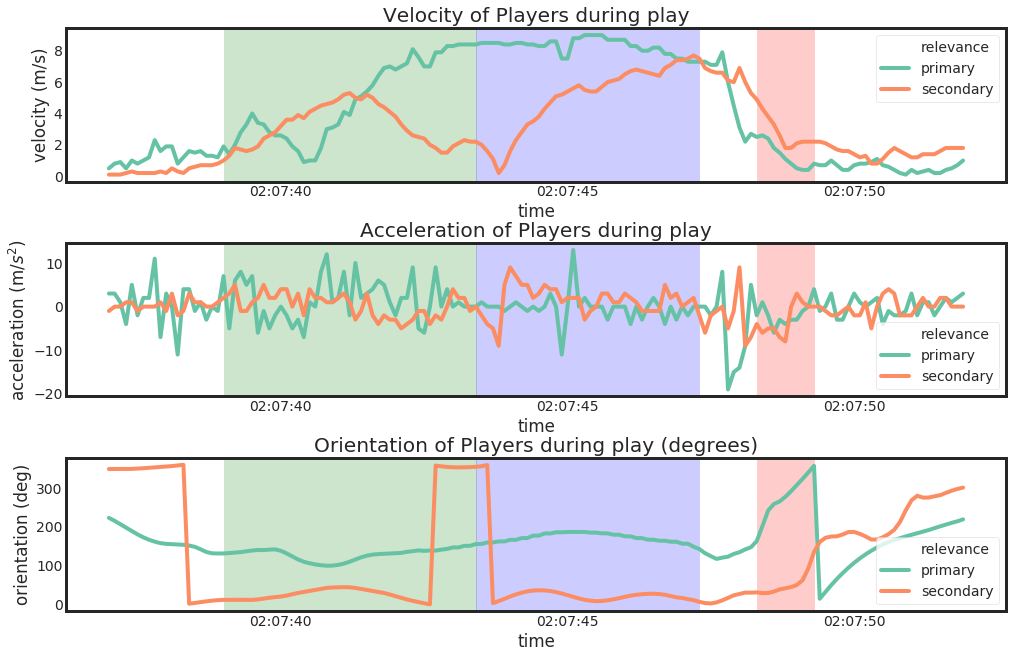

In [467]:
plot_play_motion(hashcode)

## Play plotting

In [555]:
def plot_play(hashcode):
    # Get the players involved in the play
    players_df, players = get_2_players(hashcode)
    # Get time of punt, punt reception, and tackle (TODO:not all are tackled, make more general)
    punt_time, reception_time, tackle_time = get_ngs_info(players[0].dropna())
    players_df2 = players_df[ players_df['time'] >= punt_time - 2*td]

    # Preparing plot
    f = plt.figure(figsize=(15,8))
    ax = f.add_subplot(111)
    
    # Constructing the field
    ax.set_xlim(0,120)
    ax.set_ylim(0,53.3)
    plt.axvspan(0, 10, color='blue', alpha=0.2);
    plt.axvspan(10, 110, color='green', alpha=0.2);
    plt.axvspan(110, 120, color='blue', alpha=0.2);
    
    # Yardlines 
    nums = [1,2,3,4,5,4,3,2,1]
    for i in range(len(nums)):
        for j in [5,45]:
            ax.annotate(f"{nums[i]}", xy = ((i+2)*10 - 2.5, j), size=25, color='white', alpha=1.0)
            ax.annotate("0", xy = ((i+2)*10 + 0.5, j), size=25, color='white', alpha=1.0)

    # Yard marker numbers
    xcoords = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
    for xc in xcoords:
        plt.axvline(x=xc, color='white')

    sns.scatterplot(data=players_df2, x='x', y='y');

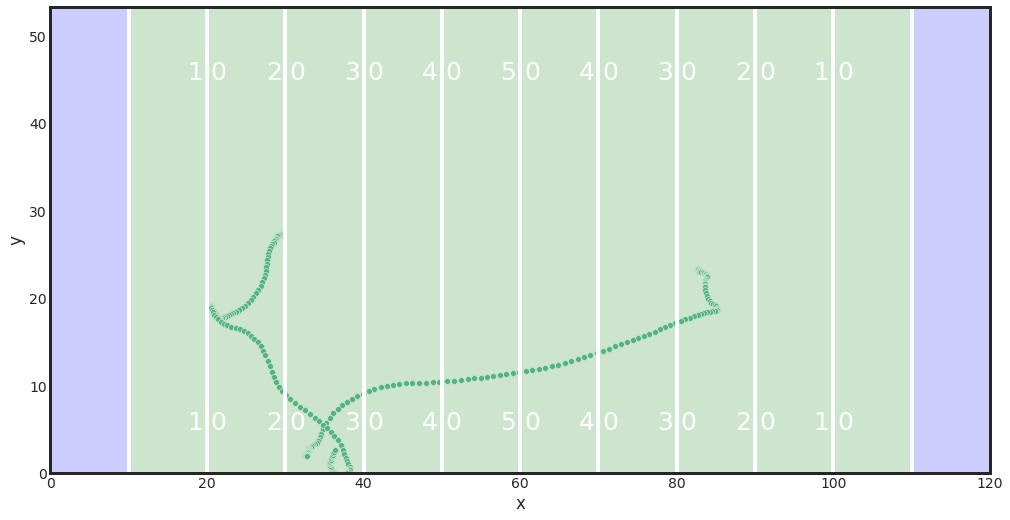

In [556]:
plot_play(hashcode)

#### Find the Position of Point of Impact?
- for tackle first

In [553]:
players_df, players = get_2_players(hashcode)

event = 'tackle'
df = players[0][ players[0]['event'] == event]
x, y = df['x'].values[0], df['y'].values[0]
print(f"({np.round(x,1)}, {np.round(y, 1)})")

(33.8, 3.3)


In [554]:
hashcode

'2016-5-3129'

## Formations
#### Positions that appear in respective formations

In [408]:
punt_return = ['VR', 'VRi', 'VRo', 'VL', 'VLo', 'VLi','PDR1','PDR2','PDR3', 'PDR4', 'PDR5',
               'PDL1','PDL2','PDL3', 'PDL4', 'PLL', 'PLL1', 'PLL2', 'PLM', 'PLR', 'PLR1', 'PLR2',  'PFB', 'PR']

punt_coverage = ['GL', 'GR','PLW', 'PLT', 'PLG', 'PLS', 'PRG', 'PRT', 'PRW','PC','PPR','P','PPL']

In [200]:
# Returns 
def get_player_roles(mergecode):
    player_roles = df_dict['play_player_role_data']
    return player_roles.loc[player_roles['role'].groupby(player_roles['hashcode']).groups[mergecode].values].role.values

# @return formations (return and coverage) for a play given hashcode
def get_formations(hashcode):
    pp_return = sorted([punt_position for punt_position in get_player_roles(hashcode) if punt_position in punt_return])
    pp_coverage = sorted([punt_position for punt_position in get_player_roles(hashcode)  if punt_position in punt_coverage])

    return_formation = '_'.join(pp_return)
    coverage_formation = '_'.join(pp_coverage)
    
    return pd.DataFrame({'hashcode': hashcode, 
                         'return_formation': return_formation, 
                         'cov_formation': coverage_formation}, index=[0])

In [409]:
formation_df_i = pd.concat([get_formations(hc) for hc in injurydf['hashcode'].values])
formation_df_c = pd.concat([get_formations(hc) for hc in controldf['hashcode'].values])
formation_df_i['injury'] = 1
formation_df_c['injury'] = 0
formation_df = pd.concat([formation_df_i, formation_df_c])

TODO: find out what the VRi, Vro, etc. is, seems to be more prevalent in injury formations

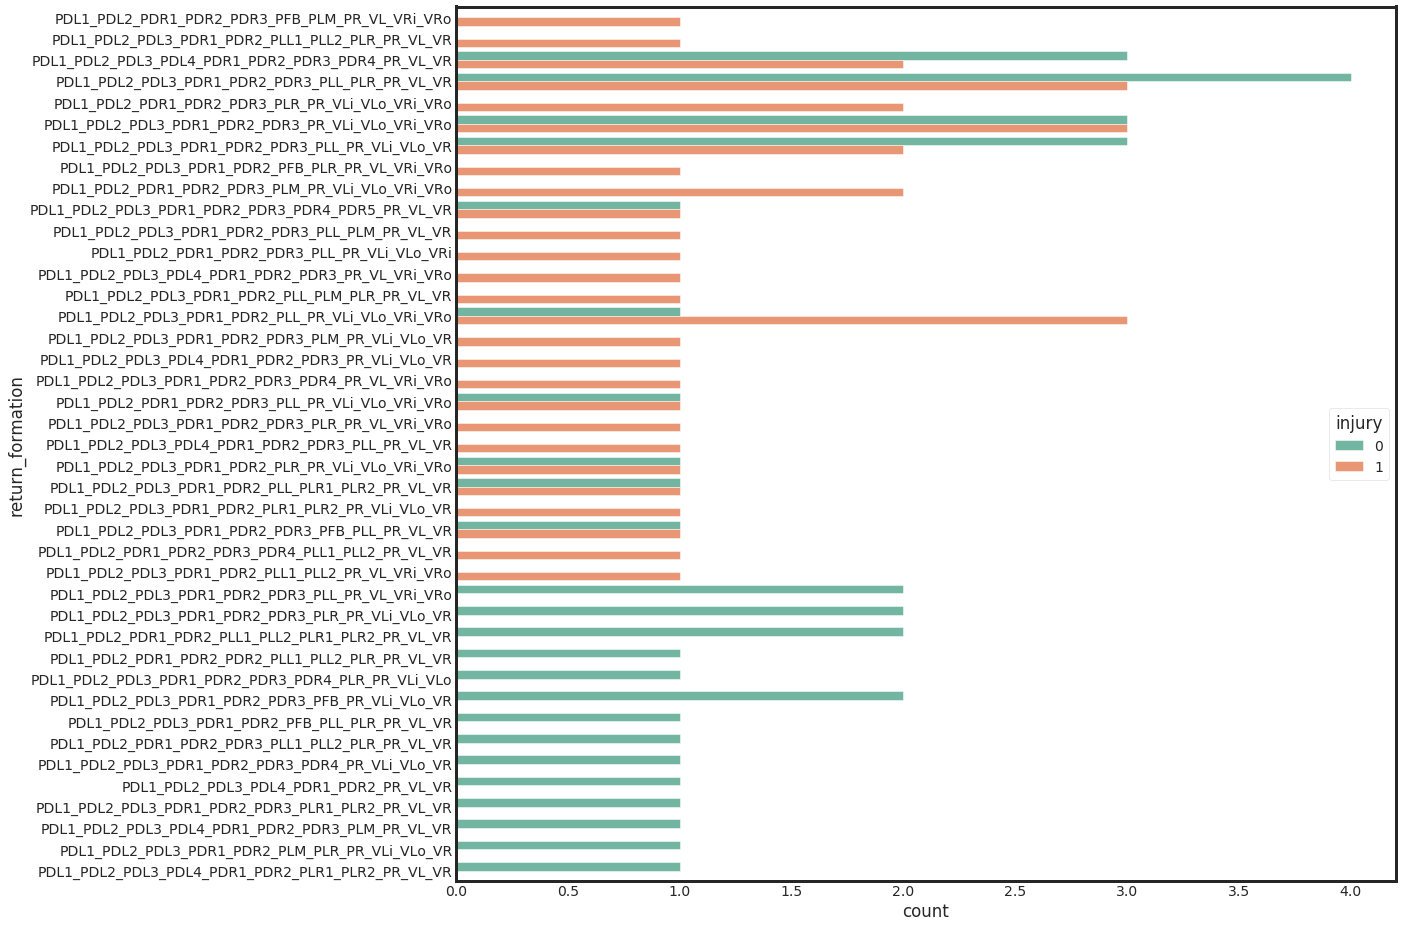

In [468]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
sns.countplot( y="return_formation", hue="injury", data=formation_df);

In [411]:
formation_df['num_return_positions'] = formation_df['return_formation'].str.split('_').apply(lambda x: len(x))
formation_df['num_return_positions'].value_counts()

11    72
10     1
9      1
Name: num_return_positions, dtype: int64

In [412]:
formation_df['num_cov_positions'] = formation_df['cov_formation'].str.split('_').apply(lambda x: len(x))
formation_df['num_cov_positions'].value_counts()

11    74
Name: num_cov_positions, dtype: int64

In [415]:
dummy_variables = ['player_activity_derived', 'turnover_related', 'primary_impact_type',
                   'primary_partner_activity_derived', 'friendly_fire']

video_review = df_dict['video_review'].copy()

for var in dummy_variables:

    video_review = pd.concat([video_review.drop(var, axis=1),
                          pd.get_dummies(video_review[var])], axis=1)
    
video_review = pd.merge(left=video_review, right=formation_df_i, on='hashcode', how='inner')
video_review = pd.concat([video_review.drop('return_formation', axis=1), pd.get_dummies(video_review['return_formation'])], axis=1)

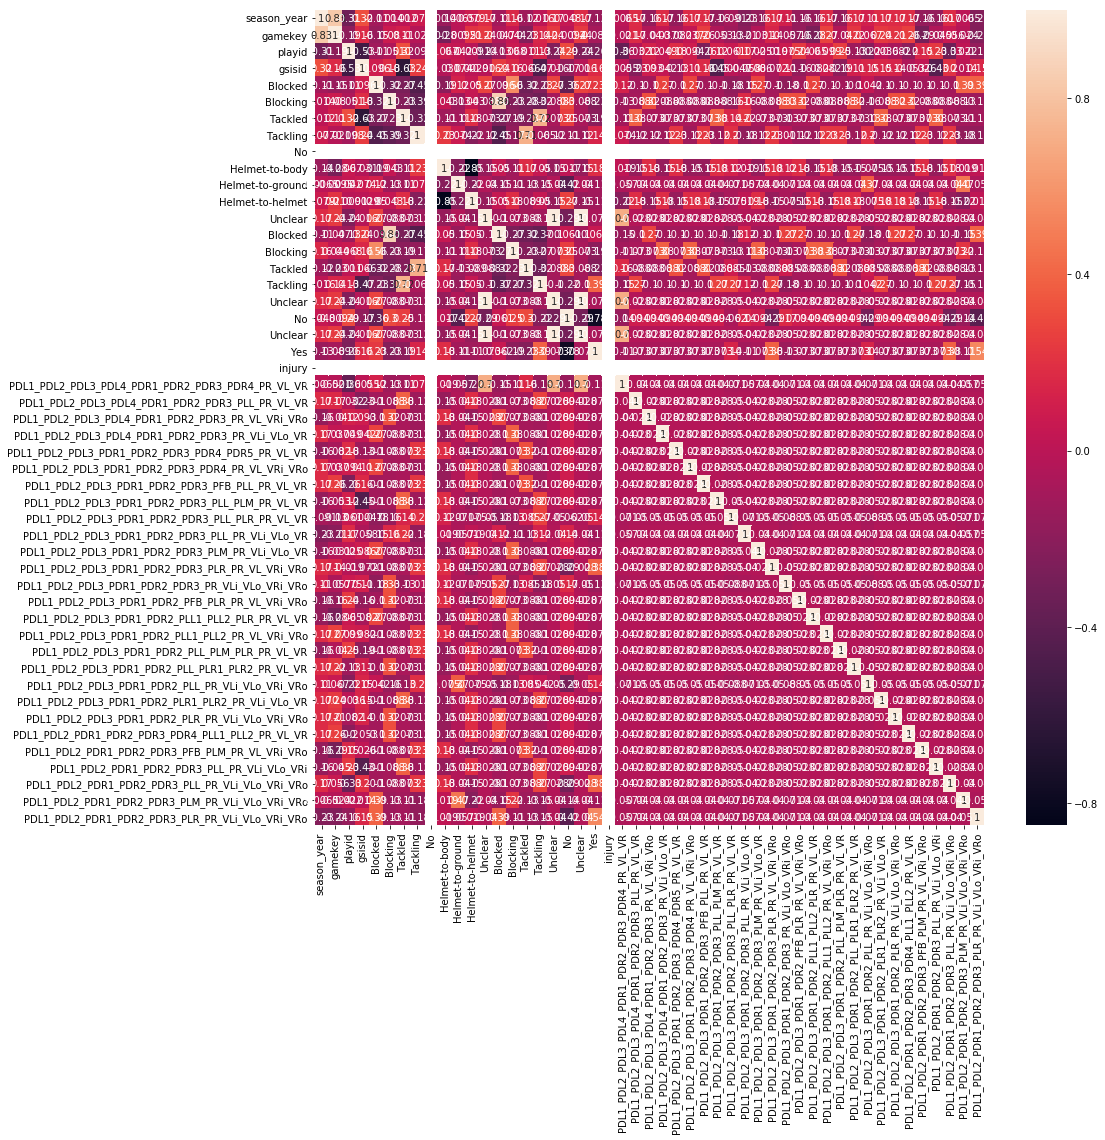

In [416]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
sns.heatmap(video_review.corr(), annot=True);

In [427]:
cols = ['season_year', 'gamekey', 'playid', 'gsisid', 'Blocked', 'Blocking',
       'Tackled', 'Tackling', 'Helmet-to-body', 'Helmet-to-ground',
       'Helmet-to-helmet', 'Unclear', 'Blocked', 'Blocking', 'Tackled',
       'Tackling', 'Unclear', 'Yes', 'injury']
vrc = video_review.corr()[cols]

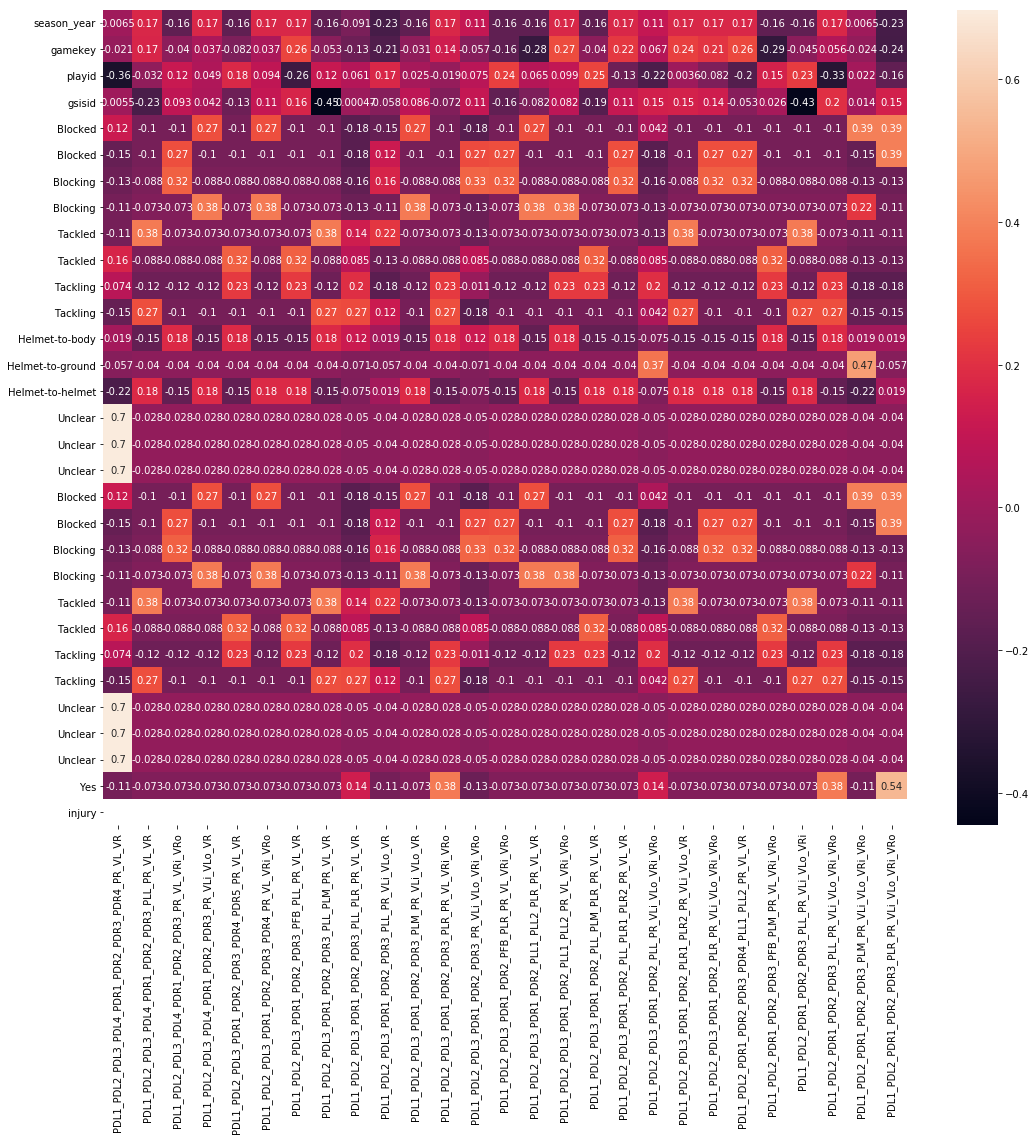

In [429]:
f = plt.figure(figsize=(18,15))
ax = f.add_subplot(111)

sns.heatmap(vrc[22:].T, annot=True);

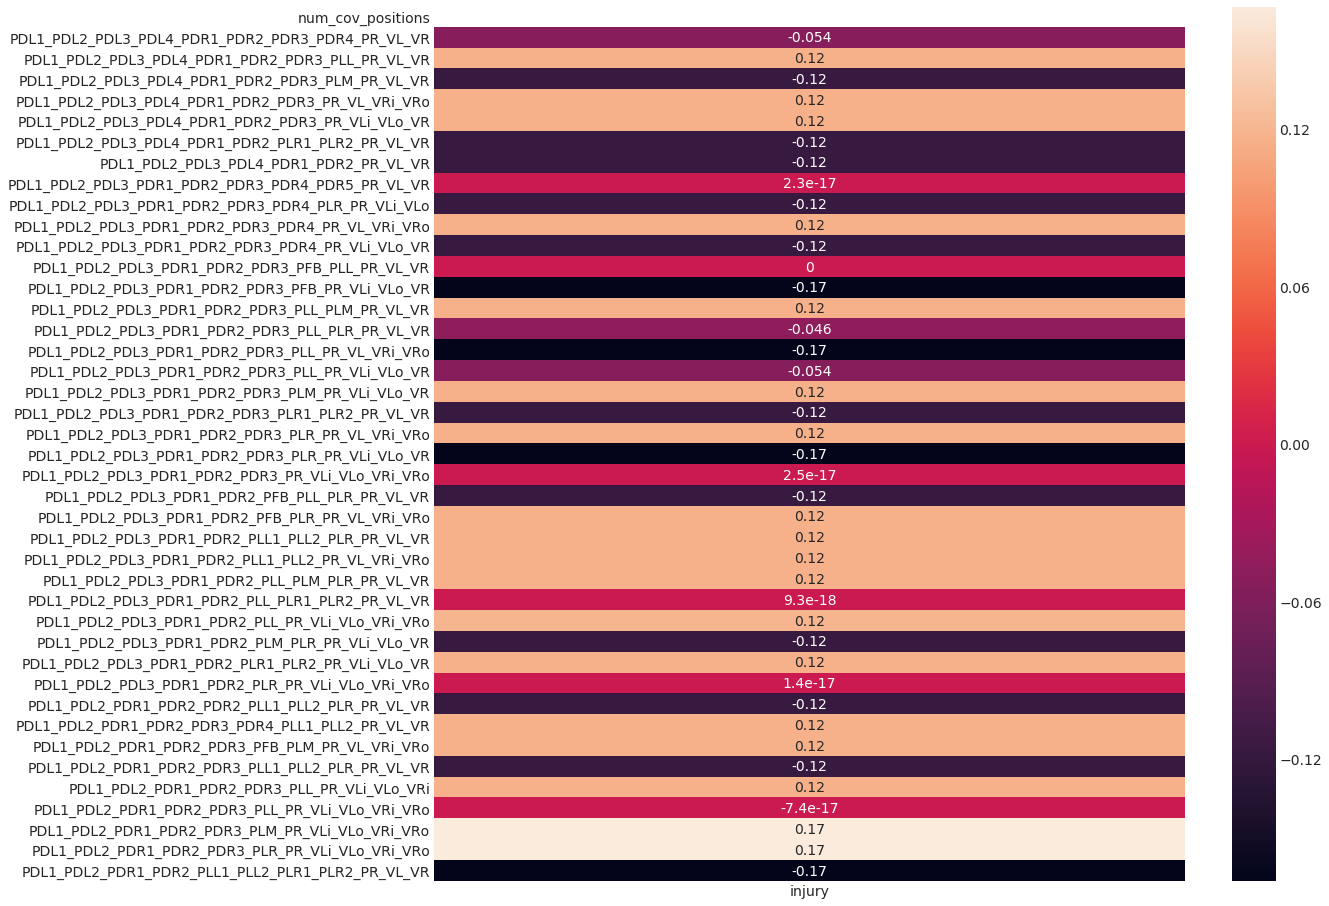

In [469]:
temp = pd.concat([formation_df.drop('return_formation', axis=1), pd.get_dummies(formation_df['return_formation'])], axis=1)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
sns.heatmap(pd.DataFrame(temp.corr().sort_values('injury').loc['injury'])[2:], annot=True);

In [362]:
players[0].dropna()

,season_year,gamekey,playid,gsisid,time,x,y,dis,o,dir,event,hashcode,td,displacement,v,relevance,a
205566,2016,5,3129,31057,2016-08-12 02:07:31.400,82.620003,23.260000,0.00,243.580002,4.470000,line_set,2016-5-3129,0.1,0.000000,-0.721148,primary,-12.187095
205589,2016,5,3129,31057,2016-08-12 02:07:37.000,82.660004,23.370001,0.05,223.070007,115.620003,ball_snap,2016-5-3129,0.1,0.053854,0.338554,primary,7.042668
206026,2016,5,3129,31057,2016-08-12 02:07:39.000,83.580002,21.570000,0.19,131.360001,165.770004,punt,2016-5-3129,0.1,0.180278,0.602771,primary,6.396815
206048,2016,5,3129,31057,2016-08-12 02:07:43.400,68.160004,13.230000,0.84,155.600006,255.429993,punt_received,2016-5-3129,0.1,0.847700,0.124801,primary,1.845207
205809,2016,5,3129,31057,2016-08-12 02:07:48.300,33.810001,3.340000,0.25,162.839996,217.970001,tackle,2016-5-3129,0.1,0.252388,-0.256419,primary,-8.966414
205831,2016,5,3129,31057,2016-08-12 02:07:50.900,32.450001,2.070000,0.01,175.029999,196.059998,penalty_flag,2016-5-3129,0.1,0.010000,-0.123599,primary,-0.309460
205851,2016,5,3129,31057,2016-08-12 02:07:51.900,32.759998,1.940000,0.10,219.080002,185.369995,play_submit,2016-5-3129,0.1,0.098489,0.277786,primary,-0.293155


In [437]:
injury_positions = []
control_positions = []

for _ in formation_df_i['return_formation'].str.split('_').values:
    injury_positions = injury_positions + _
    
for _ in formation_df_c['return_formation'].str.split('_').values:
    control_positions = control_positions + _

In [438]:
iset = set(injury_positions)
cset = set(control_positions)

In [441]:
iset.symmetric_difference(cset)

set()

In [472]:
### field location

In [470]:
ydline_num = df_dict['play_information']['yardline'].str.split().apply(lambda x: x[1])
ydline_team = df_dict['play_information']['yardline'].str.split().apply(lambda x: x[0])
own = (ydline_team != df_dict['play_information']['poss_team'].values)*1

tempdf = df_dict['play_information']

temp2 = tempdf['playdescription'].str.split(',').apply(lambda x: x[0]).str.split('yards to ').apply(lambda x: len(x))


tempdf['len'] = temp2
# if tempdf[ tempdf['len']==2]
tempdf['ydline_kicked_to'] = tempdf[ tempdf['len']==2]['playdescription'].str.split(',').apply(lambda x: x[0]).\
                                             str.split('yards to').apply(lambda x: x[1]).\
                                             str.replace('end zone', 'X 0').\
                                             str.strip().str.split(' ').apply(lambda x: x[-1])
            
            
tempdf['blocked'] = 1*tempdf[ tempdf['len']==1]['playdescription'].str.contains('BLOCKED').fillna(0)
tempdf['penalty'] = 1*tempdf[ tempdf['len']==1]['playdescription'].str.contains('PENALTY').fillna(0)

In [471]:
tempdf

,season_year,season_type,gamekey,game_date,week,playid,game_clock,yardline,quarter,play_type,poss_team,home_team_visit_team,score_home_visiting,playdescription,hashcode,len,ydline_kicked_to,blocked,penalty
0,2016,Pre,2,08/13/2016,2,191,12:30,LA 47,1,Punt,LA,LA-DAL,0 - 7,"(12:30) J.Hekker punts 52 yards to DAL 1, Cent...",2016-2-191,2,1,NaN,NaN
1,2016,Pre,2,08/13/2016,2,1132,12:08,LA 29,2,Punt,LA,LA-DAL,7 - 21,"(12:08) J.Hekker punts 51 yards to DAL 20, Cen...",2016-2-1132,2,20,NaN,NaN
2,2016,Pre,2,08/13/2016,2,1227,10:01,DAL 18,2,Punt,DAL,LA-DAL,7 - 21,"(10:01) C.Jones punts 40 yards to LA 42, Cente...",2016-2-1227,2,42,NaN,NaN
3,2016,Pre,2,08/13/2016,2,1864,00:21,DAL 46,2,Punt,LA,LA-DAL,7 - 24,"(:21) J.Hekker punts 31 yards to DAL 15, Cente...",2016-2-1864,2,15,NaN,NaN
4,2016,Pre,2,08/13/2016,2,2247,10:26,DAL 15,3,Punt,DAL,LA-DAL,14 - 24,"(10:26) M.Wile punts 40 yards to LA 45, Center...",2016-2-2247,2,45,NaN,NaN
5,2016,Pre,2,08/13/2016,2,2342,09:00,LA 50,3,Punt,LA,LA-DAL,14 - 24,"(9:00) J.Hekker punts 50 yards to end zone, Ce...",2016-2-2342,2,0,NaN,NaN
6,2016,Pre,2,08/13/2016,2,2805,00:27,LA 38,3,Punt,LA,LA-DAL,14 - 24,"(:27) J.Hekker punts 48 yards to DAL 14, Cente...",2016-2-2805,2,14,NaN,NaN
7,2016,Pre,2,08/13/2016,2,2970,13:30,LA 41,4,Punt,DAL,LA-DAL,14 - 24,"(13:30) M.Wile punts 41 yards to end zone, Cen...",2016-2-2970,2,0,NaN,NaN
8,2016,Pre,2,08/13/2016,2,3439,05:28,DAL 15,4,Punt,DAL,LA-DAL,21 - 24,"(5:28) M.Wile punts 59 yards to LA 26, Center-...",2016-2-3439,2,26,NaN,NaN
9,2016,Pre,3,08/11/2016,2,455,06:44,BLT 32,1,Punt,BLT,BLT-CAR,0 - 3,(6:44) (Punt formation) S.Koch punts 54 yards ...,2016-3-455,2,14,NaN,NaN
